Fitting model on a small sub-sample of the data
done in 0.016s.
Predicting color indices on the full image (k-means)
done in 0.017s.
Predicting color indices on the full image (random)
done in 0.033s.


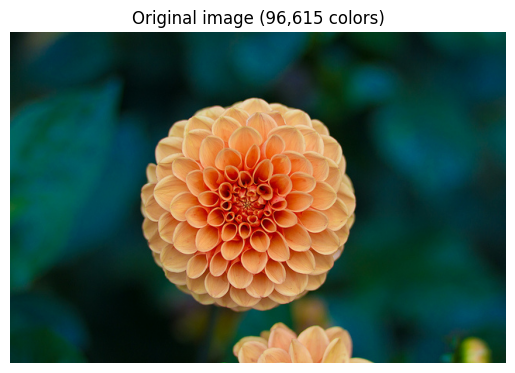

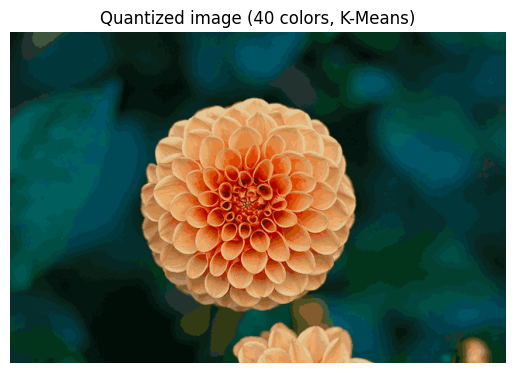

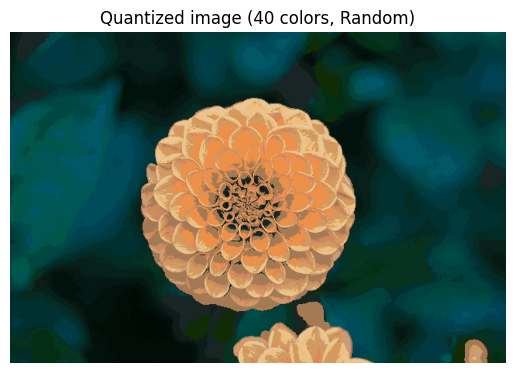

Metrics for K-means quantization:
MSE: 0.000604088510167653
PSNR: 32.18899424522621
SSIM: 0.9332758456638949

Metrics for random sampling quantization:
MSE: 0.004125398892545756
PSNR: 23.845340523366797
SSIM: 0.8885437266497801
Metrics for the original image:
MSE: 0.0
PSNR: inf
SSIM: 1.0



<ipython-input-6-4fcb266f1da0>:87: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_kmeans = structural_similarity(image_array_2d, quantized_image_kmeans_2d, multichannel=True)
<ipython-input-6-4fcb266f1da0>:92: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_random = structural_similarity(image_array_2d, quantized_image_random_2d, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
<ipython-input-6-4fcb266f1da0>:110: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_original = structural_

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

n_colors = 40

# Load the Summer Palace photo
flower = load_sample_image("flower.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves well on float data (needs to be in the range [0-1]) 
#maximum pixel value in an 8-bit image is 255, dividing by 255 normalizes the pixel values to the range [0, 1].
flower = np.array(flower, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(flower.shape) #height, width, and channels 
assert d == 3 #value of d (number of channels) is equal to 3. In image arrays, 3 channels typically represent the red, green, and blue color channels. 
image_array = np.reshape(flower, (w * h, d)) #flatten the array, change the shape of an array while preserving its data.
#  the array is flattened into a 2D representation 
#where each row represents a pixel and each column represents a color channel. 

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000) #shuffle the images to reduce bias, selesct 1000 samples
kmeans = KMeans(n_clusters=n_colors, n_init="auto", random_state=0).fit(image_array_sample) 
print(f"done in {time() - t0:0.3f}s.")

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print(f"done in {time() - t0:0.3f}s.")

codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print(f"done in {time() - t0:0.3f}s.")
#compare each pixel in the image to the colors in the randomly selected codebook. We find the closest color in the codebook for each pixel, and assign the corresponding cluster label to that pixel.
#Pairwise distance calculation is a method used to measure the similarity or dissimilarity between pairs of data points. 

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

# Display all results, alongside the original image
plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image (96,615 colors)")
plt.imshow(flower)

plt.figure(2)
plt.clf() #clear
plt.axis("off") #turns off the axis labels
plt.title(f"Quantized image ({n_colors} colors, K-Means)")
quantized_image_kmeans = recreate_image(kmeans.cluster_centers_, labels, w, h)
plt.imshow(quantized_image_kmeans)

plt.figure(3)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, Random)")
quantized_image_random = recreate_image(codebook_random, labels_random, w, h)
plt.imshow(quantized_image_random)
plt.show()






# Reshape the original image and quantized images to 2D arrays
image_array_2d = flower.reshape(-1, 3)
quantized_image_kmeans_2d = quantized_image_kmeans.reshape(-1, 3)
quantized_image_random_2d = quantized_image_random.reshape(-1, 3)

# Calculate metrics for the quantized image obtained using K-means
mse_kmeans = mean_squared_error(image_array_2d, quantized_image_kmeans_2d)
psnr_kmeans = peak_signal_noise_ratio(image_array_2d, quantized_image_kmeans_2d)
ssim_kmeans = structural_similarity(image_array_2d, quantized_image_kmeans_2d, multichannel=True)

# Calculate metrics for the quantized image obtained using random sampling
mse_random = mean_squared_error(image_array_2d, quantized_image_random_2d)
psnr_random = peak_signal_noise_ratio(image_array_2d, quantized_image_random_2d)
ssim_random = structural_similarity(image_array_2d, quantized_image_random_2d, multichannel=True)

# Print the metrics for K-means
print("Metrics for K-means quantization:")
print("MSE:", mse_kmeans)
print("PSNR:", psnr_kmeans)
print("SSIM:", ssim_kmeans)
print()

# Print the metrics for random sampling
print("Metrics for random sampling quantization:")
print("MSE:", mse_random)
print("PSNR:", psnr_random)
print("SSIM:", ssim_random)


mse_original = mean_squared_error(image_array_2d, image_array_2d)
psnr_original = peak_signal_noise_ratio(image_array_2d, image_array_2d)
ssim_original = structural_similarity(image_array_2d, image_array_2d, multichannel=True)

mse_kmeans = mean_squared_error(image_array_2d, quantized_image_kmeans_2d)
psnr_kmeans = peak_signal_noise_ratio(image_array_2d, quantized_image_kmeans_2d)
ssim_kmeans = structural_similarity(image_array_2d, quantized_image_kmeans_2d, multichannel=True)

print("Metrics for the original image:")
print("MSE:", mse_original)
print("PSNR:", psnr_original)
print("SSIM:", ssim_original)
print()

